**Importar Librerias**

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

import chardet           # para detectar la codificación de texto en archivos
import numpy as np

from sklearn import preprocessing, model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

import seaborn as sns

**Importar Dataset**

In [52]:
DATOS_DIR = '../Datos/' #carpeta donde esta el DataSet
nombre_archivo = DATOS_DIR+ 'creditcard.csv'
datos = pd.read_csv(nombre_archivo)
print(datos.head())


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

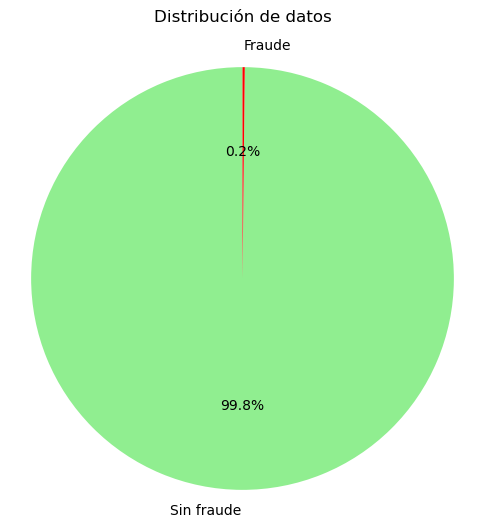

In [59]:
conteo_fraude = datos['Class'].value_counts()

# Etiquetas para el gráfico
etiquetas = ['Sin fraude', 'Fraude']  # el valor 0 es salvaje, 1 es doméstico
colores = ['lightgreen', 'red']

#  gráfico
plt.figure(figsize=(6,6))
plt.pie(conteo_fraude, labels=etiquetas, autopct='%1.1f%%', startangle=90, colors=colores)
plt.title('Distribución de datos\n')
plt.axis('equal')  # para que el círculo no salga ovalado
plt.show()

**Modelo de Autoencoder**

In [64]:
#La columna time se elimina, porque no aporta informacion util para detectar un fraude
#(Time: tiempo en segundos que transcurrio desde la primera transferencia) 
#datos.drop(['Time'], axis=1,  inplace=True)

#se normaliza los datos de la columna Amount para que tengan media 0 y desv est 1 (valores entre -1 y 1)
datos['Amount'] = StandardScaler().fit_transform(datos['Amount'].values.reshape(-1,1))
#solo se normaliza Amount, porque las variables V1 a V28 ya fueron normalizadas cuando se "encriptaron" mediante PCA

#dividir datos en entrenamiento y prueba (train y test)
X_train, X_test = train_test_split(datos, test_size= 0.2, random_state=42) # 80% train, 20% test

#especifico que los datos de entrenamiento sean los de Class=0 (transferencias sin fraude)
#el autoencoder entonces se entrena solo con datos normales (sin fraude). Porque el objetivo es que el autoencoder aprenda solo a reconstruir el
#comportamiento normal
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
X_train = X_train.values

Y_test = X_test['Class'] #guardo en Y_test la columna Class
X_test = X_test.drop(['Class'], axis=1) #elimino la columna Class de X_test (ya que solo se utilizan columnas V1 a V28 y Amount)
X_test = X_test.values #convierto dataframe X_test a array

print(type(X_train.shape))
print(X_train.shape)

<class 'tuple'>
(227451, 29)


In [74]:
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import EarlyStopping

dimension_entrada = X_train.shape[1] #29 (28 variables + Amount)
capa_entrada = Input(shape=(dimension_entrada,))

encoder = Dense(20, activation='tanh')(capa_entrada) #capa de entrada, 20 neuronas
encoder = Dense(14, activation='relu')(encoder) #14 neuronas

decoder = Dense(20, activation='tanh')(encoder)
decoder = Dense(29, activation='relu')(decoder)

autoencoder = Model(inputs=capa_entrada, outputs=decoder)

from keras.optimizers import SGD
#utilizo descenso del gradiente estocastico (SGD) como funcion para ajustar los pesos y minimizar el error
sgd = SGD(learning_rate=0.01)
autoencoder.compile(optimizer='sgd', loss='mse')

#ENTRENAMIENTO

#implemento para temprana para evitar sobreajuste y que el modelo comience a memorizar. Para esto, el modelo espera 5 epocas (patience) hasta que
#el error mejore.
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


tam_lote=32
autoencoder.fit(X_train, X_train, epochs= 100, batch_size=tam_lote, shuffle=True, validation_data=(X_test,X_test), callbacks=[early_stopping], verbose=1)
#epocas=100 --> indica la cantidad de veces que se iteran los datos en el entrenamiento. Se realizan 100 iteraciones completas sobre los datos
#batch_size=32 --> el dataset se divide en mini lotes de 32 datos. Cada 32 muestras, se calcula un error y se ajustan los pesos 
#Se utiliza X_train, X_train, porque en un autoencoder el objetivo es que la salida sea igual a la entrada.


Epoch 1/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.9880 - val_loss: 0.8933
Epoch 2/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.8825 - val_loss: 0.8531
Epoch 3/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.8007 - val_loss: 0.8260
Epoch 4/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.7794 - val_loss: 0.7966
Epoch 5/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.7527 - val_loss: 0.7800
Epoch 6/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.7487 - val_loss: 0.7665
Epoch 7/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 0.7474 - val_loss: 0.7552
Epoch 8/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.7085 - val_loss: 0.7469
Epoch 9/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.7078 - val_loss: 0.7400
Epoch 10/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.7394 - val_loss: 0.7334
Epoch 11/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.7204 - val_loss: 0.7270
Epoch 12/100
71

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 645us/step
(56962, 29)


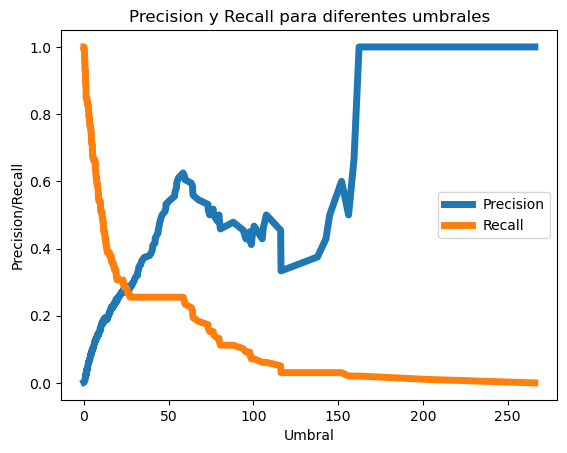

In [78]:
#METRICAS

# Predicción X_test -> Autoencoder -> X_pred

X_pred = autoencoder.predict(X_test) #el autoencoder recibe X_test y trata de reconstruirlo
#(X_test contiene todo el conjunto de datos: transacciones con fraude y sin fraude)
ecm = np.mean(np.power(X_test-X_pred,2), axis=1) #se promedian los 29 errores por cada muestra
print(X_pred.shape)

# Gráfica precision-recall para determinar el umbral
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report
precision, recall, umbral = precision_recall_curve(Y_test, ecm)

plt.plot(umbral, precision[1:], label="Precision",linewidth=5)
plt.plot(umbral, recall[1:], label="Recall",linewidth=5)
plt.title('Precision y Recall (transacciones con fraude)  para diferentes umbrales')
plt.xlabel('Umbral')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

**Se observa la matriz de confusion con un umbral de 0.75**

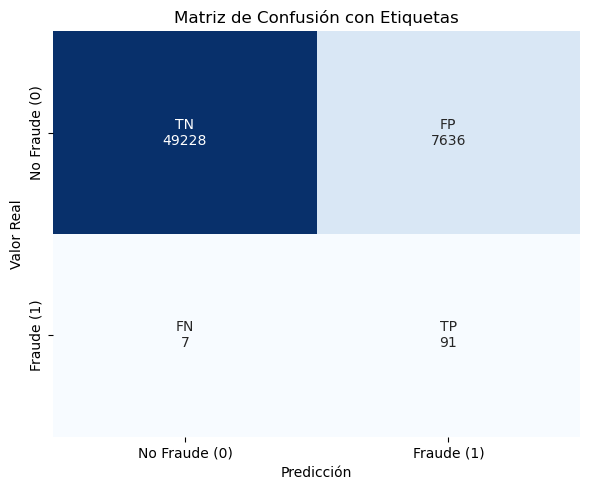

Confusion matrix Training:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     56864
           1       0.01      0.93      0.02        98

    accuracy                           0.87     56962
   macro avg       0.51      0.90      0.48     56962
weighted avg       1.00      0.87      0.93     56962



In [86]:
# Matriz de confusión
umbral_fijo = 0.75 #defino umbral fijo de ECM para decidir si una transaccion es fraudulenta o no

#si el error es mayor al umbral, clasifica como fraude:
Y_pred = [1 if e > umbral_fijo else 0 for e in ecm]

############################################################################
# Calcular matriz de confusión
conf_matrix = confusion_matrix(Y_test, Y_pred)

# Etiquetas personalizadas para cada celda: ['TN', 'FP'], ['FN', 'TP']
cell_labels = np.array([['TN', 'FP'], ['FN', 'TP']])

# Construir anotaciones combinadas: etiqueta + valor numérico
annot = np.empty_like(conf_matrix).astype(str)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        annot[i, j] = f"{cell_labels[i, j]}\n{conf_matrix[i, j]}"

# Crear gráfico
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=annot, fmt='', cmap='Blues', cbar=False,
            xticklabels=['No Fraude (0)', 'Fraude (1)'],
            yticklabels=['No Fraude (0)', 'Fraude (1)'])

plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión con Etiquetas')
plt.tight_layout()
plt.show()
#############################################################################

report = classification_report(Y_test,Y_pred)
print("Confusion matrix Training:\n%s" % report) 


**Se Observa que se detectaron correctamente 91 transacciones fraudulentas (con un total de 98), pero a su vez habiendo detectado falsamente 7636**

**Probamos un umbral mas alto de 15**

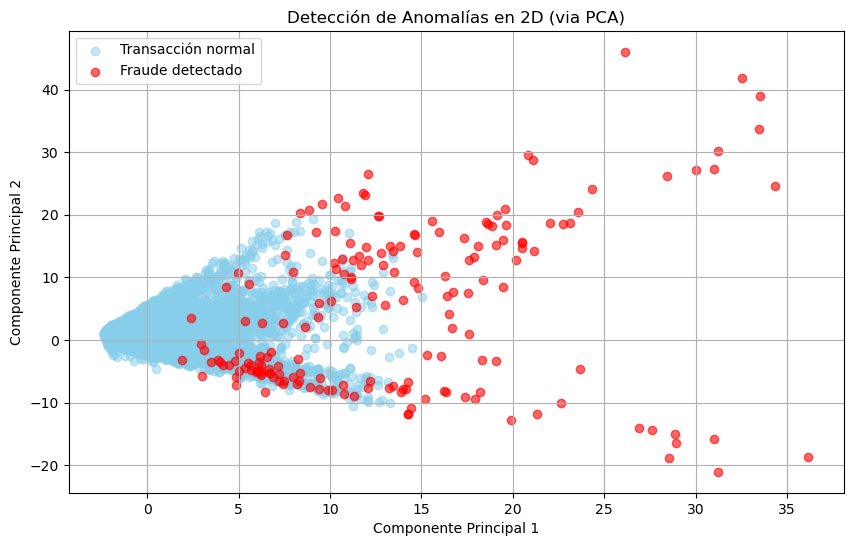

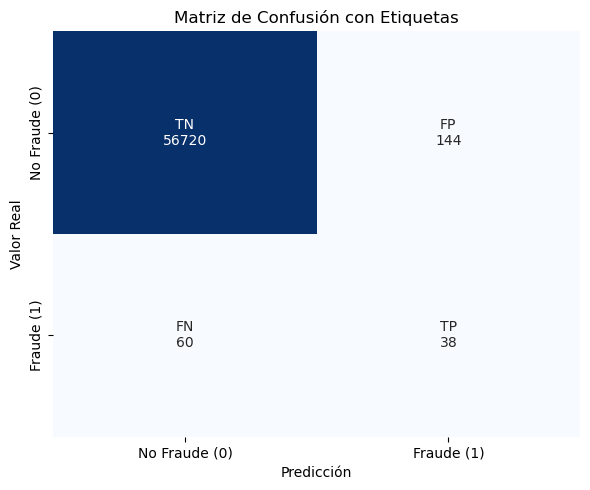

Confusion matrix Training:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.21      0.39      0.27        98

    accuracy                           1.00     56962
   macro avg       0.60      0.69      0.63     56962
weighted avg       1.00      1.00      1.00     56962



In [100]:
# Matriz de confusión
umbral_fijo = 15 #defino umbral fijo de ECM para decidir si una transaccion es fraudulenta o no

#si el error es mayor al umbral, clasifica como fraude:
Y_pred = [1 if e > umbral_fijo else 0 for e in ecm]

from sklearn.decomposition import PCA
# Reducimos a 2 dimensiones
pca = PCA(n_components=2)
X_reducido = pca.fit_transform(X_test)

# Convertimos a array por si no lo es
Y_test = np.array(Y_test)
Y_pred = np.array(Y_pred)

# Clasificamos según predicción
anomalías_detectadas = (Y_pred == 1)
normales_detectadas = (Y_pred == 0)

# Gráfico
plt.figure(figsize=(10, 6))

# Normales en celeste
plt.scatter(X_reducido[normales_detectadas, 0], X_reducido[normales_detectadas, 1],
            c='skyblue', label='Transacción normal', alpha=0.5)

# Anomalías en rojo
plt.scatter(X_reducido[anomalías_detectadas, 0], X_reducido[anomalías_detectadas, 1],
            c='red', label='Fraude detectado', alpha=0.6)

plt.title('Detección de Anomalías en 2D (via PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True)
plt.show()



############################################################################
# Calcular matriz de confusión
conf_matrix = confusion_matrix(Y_test, Y_pred)

# Etiquetas personalizadas para cada celda: ['TN', 'FP'], ['FN', 'TP']
cell_labels = np.array([['TN', 'FP'], ['FN', 'TP']])

# Construir anotaciones combinadas: etiqueta + valor numérico
annot = np.empty_like(conf_matrix).astype(str)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        annot[i, j] = f"{cell_labels[i, j]}\n{conf_matrix[i, j]}"

# Crear gráfico
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=annot, fmt='', cmap='Blues', cbar=False,
            xticklabels=['No Fraude (0)', 'Fraude (1)'],
            yticklabels=['No Fraude (0)', 'Fraude (1)'])

plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión con Etiquetas')
plt.tight_layout()
plt.show()
#############################################################################

report = classification_report(Y_test,Y_pred)
print("Confusion matrix Training:\n%s" % report) 

**Detecto correctamente 38 transacciones fraudulentas (de 98),menos que en el caso anterior, pero tambien detecto falsamente 144 transacciones fraudulentas, es decir menos falsos positivos**